# This file builds Swin3D Transformer and modifies the head for transfer learning

In [1]:
#|default_exp model

In [2]:
#| export
import torch
from torchvision.models.video import swin3d_s, Swin3D_S_Weights
from torch import nn
import matplotlib.pyplot as plt

In [3]:
import sys
sys.path.append('..')

from federated_har.datasets import *

In [4]:
torch.cuda.is_available()

True

In [5]:
model = swin3d_s(weights=Swin3D_S_Weights.DEFAULT)

In [6]:
model.head

Linear(in_features=768, out_features=400, bias=True)

For Transfer Learning, we can subtitute the head with a new linear layer that better suits our needs. Only the head needs to be trained as everything else is pretrained with Kinetics 400 dataset

In [7]:
for param in model.parameters():
    param.requires_grad = False

In [8]:
num_ftrs = model.head.in_features

In [9]:
model.head = nn.Linear(in_features=num_ftrs, out_features=3)

In [10]:
#| export
def create_model(num_out):
    """
    Loads pretrained model and freezes all layers except new custom head layer

    Args:
        num_out (int): number of classes to output

    Returns: 
        Swin3D transformer Small Pytorch model
    """
    model = swin3d_s(weights=Swin3D_S_Weights.DEFAULT)
    for param in model.parameters():
        param.requires_grad = False

    num_ftrs = model.head.in_features
    model.head = nn.Linear(in_features=num_ftrs, out_features=num_out)
    return model

# Helper Functions for Testing Training and for Flower Framework

In [11]:
#| export
def train(net, trainloader, optimizer, epochs):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    net.train()
    for _ in range(epochs):
        for images, labels in trainloader:
            optimizer.zero_grad()
            preds = net(images)
            loss = criterion(preds, labels)
            loss.backward()
            optimizer.step()
    return net

In [12]:
#| export
def test(net, testloader, device='cpu'):
    """Validate the network on the entire test set."""
    net.to(device)
    criterion = torch.nn.CrossEntropyLoss()
    correct, loss = 0, 0.0
    net.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
    accuracy = correct / len(testloader.dataset)
    return loss, accuracy

In [13]:
train_dl, test_dl = create_dataloaders('../kin6-mini/train', '../kin6-mini/test', clip_length=32, bs=4)

In [14]:
len(train_dl.dataset), len(test_dl)

(30, 8)

In [15]:
model = create_model(3)
optim = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
optim = torch.optim.Adam(model.parameters())

In [16]:
device = 'cpu'

In [17]:
criterion = torch.nn.CrossEntropyLoss()
model.to(device)
losses = []
for epoch in range(3):
    print(f'epoch {epoch}')
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        loss = criterion(preds, yb)
        losses.append(loss.detach().cpu())
        loss.backward()
        optim.step()
        optim.zero_grad()

epoch 0


/home/leevi/miniconda3/envs/FL/lib/python3.11/site-packages/torchvision/io/video.py:161: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")


epoch 1
epoch 2


In [18]:
test(model, test_dl, device) 

(2.689805328845978, 0.9333333333333333)

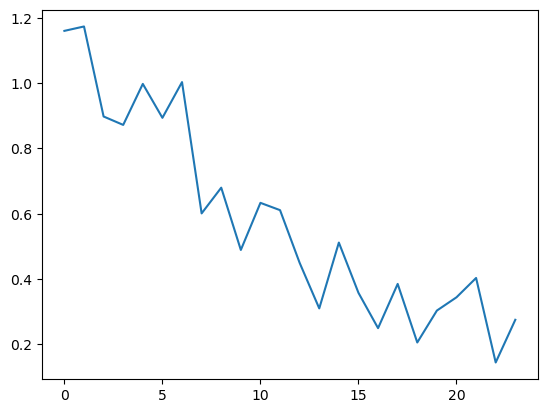

In [19]:
plt.plot(range(len(losses)), losses)

# Export

In [20]:
import nbdev; nbdev.nbdev_export()